In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

import ray
from ray.rllib.algorithms.ppo import PPOConfig

from src.parsers import HMParser
from src.resources import Aggregator, Generator, Load, Storage, Vehicle
from src.algorithms.rl import EnergyCommunitySequentialV0

2024-03-26 22:44:33,279	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

data = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data.parse()

In [3]:
# Define resources

resources = []

LOAD_FACTOR = 1

# Add the generators
for i in range(data.generator['p_forecast'].shape[0]):
    resources.append(Generator(name='generator_{:02d}'.format(i+1),
                               value=np.zeros(data.generator['p_forecast'][i].shape),
                               lower_bound=np.zeros(data.generator['p_forecast'][i].shape),
                               upper_bound=data.generator['p_forecast'][i],
                               cost=data.generator['cost_parameter_b'][i],
                               cost_nde=data.generator['cost_nde'][i],
                               is_renewable=data.generator['type_generator'][i]))

# Add the loads
for i in range(data.load['p_forecast'].shape[0]):
    resources.append(Load(name='load_{:02d}'.format(i+1),
                          value=data.load['p_forecast'][i] * LOAD_FACTOR,
                          lower_bound=np.zeros(data.load['p_forecast'][i].shape),
                          upper_bound=data.load['p_forecast'][i] * LOAD_FACTOR,
                          cost=np.ones(data.load['p_forecast'][i].shape),
                          cost_cut=data.load['cost_cut'][i],
                          cost_reduce=data.load['cost_reduce'][i],
                          cost_ens=data.load['cost_ens'][i]))
    
# Add the storage
for i in range(data.storage['p_charge_limit'].shape[0]):
    resources.append(Storage(name='storage_{:02d}'.format(i+1),
                             value=data.storage['initial_state'][i] * np.ones(data.storage['p_charge_limit'].shape[1]),
                             lower_bound=np.ones(data.storage['p_charge_limit'].shape[0]) * data.storage['energy_min_percentage'][i],
                             upper_bound=(data.storage['energy_capacity'] * 
                                          np.ones(data.storage['p_charge_limit'].shape[0])),
                             cost=np.ones(data.storage['p_charge_limit'].shape[0]),
                             cost_discharge=data.storage['discharge_price'][i],
                             cost_charge=data.storage['charge_price'][i],
                             capacity_max=data.storage['energy_capacity'][i],
                             capacity_min=data.storage['energy_min_percentage'][i],
                             initial_charge=data.storage['initial_state'][i],
                             discharge_efficiency=data.storage['discharge_efficiency'][i],
                             discharge_max=data.storage['p_discharge_limit'][i],
                             charge_efficiency=data.storage['charge_efficiency'][i],
                             charge_max=data.storage['p_charge_limit'][i],
                             capital_cost=np.array([0.05250, 0.10500, 0.01575])))
    
# Define the Electric Vehicles
for i in np.arange(data.vehicle['e_capacity_max'].shape[0]):
    new_ev = Vehicle(name='ev_{:02d}'.format(i + 1),
                     value=data.vehicle['min_technical_soc'][i] * np.ones(data.vehicle['schedule_charge'][i, :].shape),
                     lower_bound=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['min_technical_soc'][i] * data.vehicle['e_capacity_max'][i],
                     upper_bound=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['e_capacity_max'][i],
                     cost = np.zeros(data.vehicle['schedule_charge'][i].shape),
                     cost_discharge=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                    data.vehicle['discharge_price'][i, 0],
                     cost_charge=np.ones(data.vehicle['schedule_charge'][i].shape) * \
                                 data.vehicle['charge_price'][i, 0],
                     capacity_max=data.vehicle['e_capacity_max'][i],
                     initial_charge=data.vehicle['min_technical_soc'][i],
                     min_charge=data.vehicle['min_technical_soc'][i] * data.vehicle['e_capacity_max'][i],
                     discharge_efficiency=data.vehicle['charge_efficiency'][i],
                     charge_efficiency=data.vehicle['charge_efficiency'][i],
                     schedule_connected=data.vehicle['schedule'][i],
                     schedule_discharge=data.vehicle['schedule_discharge'][i],
                     schedule_charge=data.vehicle['schedule_charge'][i],
                     schedule_requirement_soc=data.vehicle['schedule_departure_soc'][i],
                     schedule_arrival_soc=data.vehicle['schedule_arrival_soc'][i]
                     )
    resources.append(new_ev)
    
# Append Aggregator
resources.append(Aggregator(name='aggregator',
                            value=np.zeros(data.load['p_forecast'][0, :].shape),
                            lower_bound=np.zeros(data.load['p_forecast'][0, :].shape),
                            upper_bound=data.peers['import_contracted_p_max'][0, :],
                            cost=data.peers['buy_price'][0, :],
                            imports=np.zeros(data.load['p_forecast'][0, :].shape),
                            exports=np.zeros(data.load['p_forecast'][0, :].shape),
                            import_cost=data.peers['buy_price'][0, :],
                            export_cost=data.peers['sell_price'][0, :],
                            import_max=data.peers['import_contracted_p_max'][0, :],
                            export_max=data.peers['export_contracted_p_max'][0, :]))

In [4]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunitySequentialV0(resources=resources,
                                       import_penalty=1000,
                                       export_penalty=1000,
                                       storage_action_penalty=500,
                                       ev_action_penalty=500,
                                       ev_requirement_penalty=700,
                                       balance_penalty=1000)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    # print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [5]:
resources[0].__dict__

{'name': 'generator_01',
 'value': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'lower_bound': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'upper_bound': array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5061133875, 1.4411243165, 3.394061953,
        5.741970125, 7.572848065, 8.76071385, 9.415491925, 9.374454205,
        8.620903585, 7.44523669, 5.628980655, 3.1658828705, 1.3267300085,
        0.467651776, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object),
 'cost': array([0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
        0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
        0.08, 0.08], dtype=object),
 'is_renewable': 2.0,
 'is_active': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 'gen_nde': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [6]:
# Check for environment errors

ray.rllib.utils.check_env(env=temp_env)

In [7]:
# Aux function to assign policies

def assign_policies(env):

    policies = {}
    for agent in env.agents:
        policies[agent] = (None,
                           env.observation_space[agent],
                           env.action_space[agent],
                           {})
    return policies

# policies = assign_policies(env=temp_env)

In [8]:
# Create the policies dictionary

def assign_group_policies(env):
    
    policies = {'generator': (None,
                              env.observation_space['generator_01'],
                                env.action_space['generator_01'],
                                {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                'aggregator': (None,
                               env.observation_space['aggregator'],
                               env.action_space['aggregator'],
                               {})           
                }
    
    return policies

policies = assign_group_policies(env=temp_env)

In [ ]:
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env

ray.shutdown()
ray.init()

IMPORT_PENALTY = 100
EXPORT_PENALTY = 100
STORAGE_ACTION_PENALTY = 1
EV_ACTION_PENALTY = 1
EV_REQUIREMENT_PENALTY = 3000
BALANCE_PENALTY = 2000

register_env("EC_Multi", lambda config: EnergyCommunitySequentialV0(resources=resources,
                                                                    import_penalty=IMPORT_PENALTY,
                                                                    export_penalty=EXPORT_PENALTY,
                                                                    storage_action_penalty=STORAGE_ACTION_PENALTY,
                                                                    ev_action_penalty=EV_ACTION_PENALTY,
                                                                    ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                                                    balance_penalty=BALANCE_PENALTY),
             )

# Define the PPOConfig
config = PPOConfig()
config = config.environment(env="EC_Multi")
config = config.training(train_batch_size=240,
                         lr=2e-4,
                         gamma=0.99,
                         use_gae=True,
                         use_critic=True)
config = config.framework('torch')
config = config.rollouts(batch_mode='complete_episodes',
                         num_rollout_workers=10,
                         rollout_fragment_length='auto')
config = config.multi_agent(policies=policies,
                            policy_mapping_fn=(lambda agent_id, episode, worker, **kwargs: 
                            'generator' if agent_id.startswith('generator') else
                            'storage' if agent_id.startswith('storage') else
                            'ev' if agent_id.startswith('ev') else
                            'aggregator'))
config = config.exploration(exploration_config={})

# Use the config's `build()` method to construct a PPO object.
algo = config.build()

# Train for n iterations and report results (mean episode rewards).
checkpoint = None
for i in range(20):
    results = algo.train()
    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    #if results['episode_reward_mean'] > -50.0:
    #    break

    # Save the checkpoint to disk.
checkpoint = algo.save()
print("checkpoints saved at", checkpoint)

In [25]:
# Check the results
# Create a new env
test_env = EnergyCommunitySequentialV0(resources=resources,
                                       import_penalty=IMPORT_PENALTY,
                                       export_penalty=EXPORT_PENALTY,
                                       storage_action_penalty=STORAGE_ACTION_PENALTY,
                                       ev_action_penalty=EV_ACTION_PENALTY,
                                       ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                       balance_penalty=BALANCE_PENALTY)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

# Set up the order of the agents
sequence = test_env._agent_sequence
current_idx = 0
while not terminations['__all__'] and not truncations['__all__']:
    
    current_agent = test_env.agents[sequence[current_idx]]
    
    current_policy = 'generator' if sequence[current_idx].startswith('generator') else \
                     'storage' if sequence[current_idx].startswith('storage') else \
                     'ev' if sequence[current_idx].startswith('ev') else \
                     'aggregator'
    
    action_dict = {current_agent.name: algo.compute_single_action(observation=obs[current_agent.name],
                                                                  policy_id=current_policy)}

    obs, rewards, terminations, truncations, info = test_env.step(action_dict)
    # print('Observation: {}'.format(obs))
    print('Reward: {}'.format(rewards))
    print('Infos: {}\n'.format(info))
    
    current_idx = (current_idx + 1) % len(sequence)

Reward: {}
Infos: {'generator_02': {'value': 0.0}}

Reward: {}
Infos: {'generator_03': {'value': 0.0}}

Reward: {}
Infos: {'generator_04': {'value': 0.0}}

Reward: {}
Infos: {'generator_05': {'value': 0.0}}

Reward: {}
Infos: {'generator_06': {'value': 0.0}}

Reward: {}
Infos: {'generator_07': {'value': 0.0}}

Reward: {}
Infos: {'ev_01': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_02': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_03': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_04': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'ev_05': {'current': 0.2, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_01': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_02': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {'storage_03': {'current': 0.8, 'charge': 0.0, 'discharge': 0.0}}

Reward: {}
Infos: {}

Reward: {'g

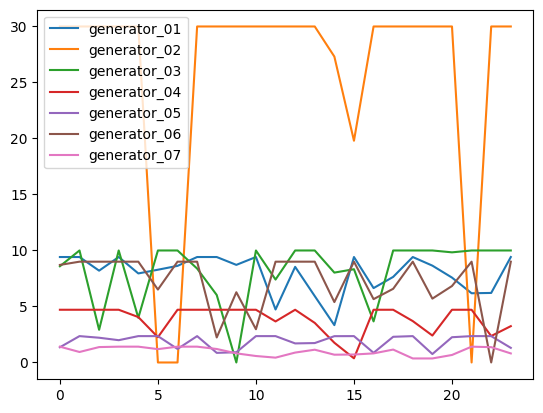

In [26]:
# Plot the generator power output

plt.figure()

for i in range(data.generator['p_forecast'].shape[0]):
    plt.plot(test_env.generators[i].value)
    
plt.legend(['generator_{:02d}'.format(i+1) for i in range(data.generator['p_forecast'].shape[0])])
plt.show()

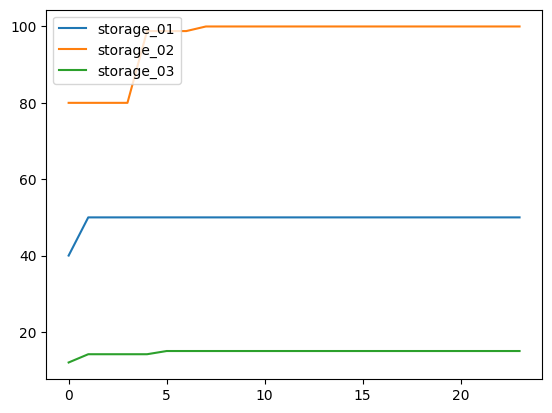

In [27]:
# Plot the storage state of charge

plt.figure()

for i in range(data.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.legend(['storage_{:02d}'.format(i+1) for i in range(data.storage['p_charge_limit'].shape[0])])
plt.show()

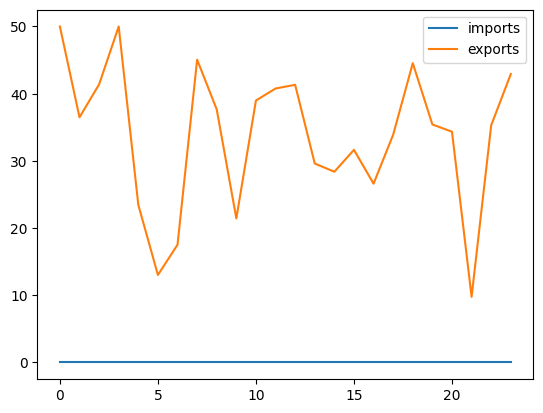

In [28]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

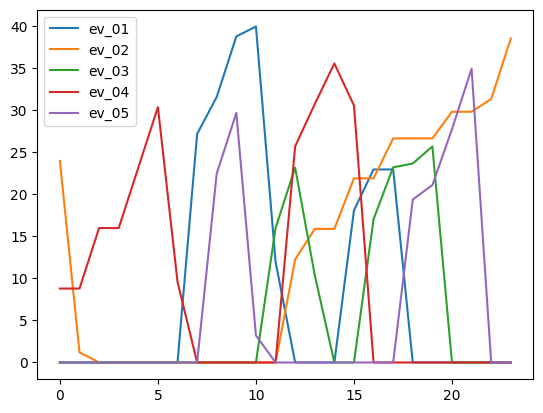

In [29]:
# Check EVs

plt.figure()

for i in test_env.evs:
    plt.plot(test_env.history[-1][str(i)].value * test_env.history[-1][str(i)].capacity_max)
    
plt.legend(['ev_{:02d}'.format(i+1) for i in range(data.vehicle['e_capacity_max'].shape[0])])

plt.show()

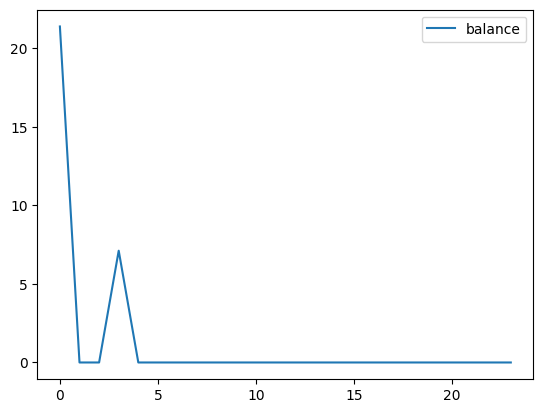

In [30]:
# Plot the balance history

plt.figure()

plt.plot(test_env.balance_history)
plt.legend(['balance'])

plt.show()

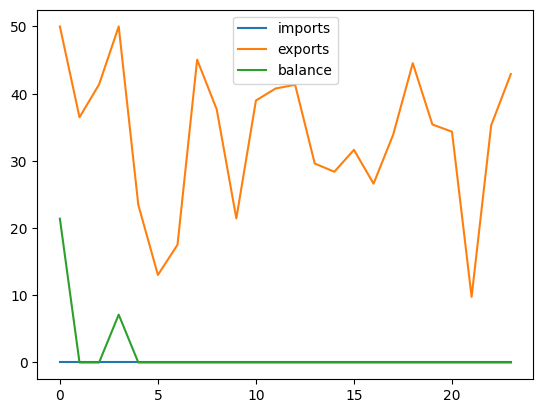

In [31]:
# Imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports)
plt.plot(test_env.aggregator.exports)

plt.plot(test_env.balance_history)

plt.legend(['imports', 'exports', 'balance'])
plt.show()

In [13]:
data.vehicle

{'arrive_time_period': array([[8.0, 16.0],
        [1.0, 13.0],
        [12.0, 17.0],
        [1.0, 13.0],
        [9.0, 19.0]], dtype=object),
 'departure_time_period': array([[12.0, 18.0],
        [2.0, 24.0],
        [14.0, 20.0],
        [7.0, 16.0],
        [11.0, 22.0]], dtype=object),
 'place': array([[2.0, 1.0],
        [1.0, 2.0],
        [1.0, 3.0],
        [3.0, 3.0],
        [3.0, 1.0]], dtype=object),
 'used_soc_percentage_arriving': array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=object),
 'soc_percentage_arriving': array([[0.5, 0.4],
        [0.4, 0.3],
        [0.4, 0.3],
        [0.4, 0.5],
        [0.4, 0.3]], dtype=object),
 'soc_required_exit': array([[0.7, 0.5],
        [0.5, 1.0],
        [0.5, 0.45],
        [0.7, 0.65],
        [0.5, 0.45]], dtype=object),
 'p_charge_max_contracted': array([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=object),
 'p_disc